<a href="https://colab.research.google.com/github/DhyeyR-007/Neural-Style-Transfer/blob/main/Method2_Controlled_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import dependencies

import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import cv2

import PIL
from tensorflow.keras import Model

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=True, weights="imagenet")

for layers in vgg.layers:
  print(f"{layers.name} -------> {layers.output_shape}")

574710816/574710816 [==============================] - 4s 0us/step
input_1 -------> [(None, 224, 224, 3)]
block1_conv1 -------> (None, 224, 224, 64)
block1_conv2 -------> (None, 224, 224, 64)
block1_pool -------> (None, 112, 112, 64)
block2_conv1 -------> (None, 112, 112, 128)
block2_conv2 -------> (None, 112, 112, 128)
block2_pool -------> (None, 56, 56, 128)
block3_conv1 -------> (None, 56, 56, 256)
block3_conv2 -------> (None, 56, 56, 256)
block3_conv3 -------> (None, 56, 56, 256)
block3_conv4 -------> (None, 56, 56, 256)
block3_pool -------> (None, 28, 28, 256)
block4_conv1 -------> (None, 28, 28, 512)
block4_conv2 -------> (None, 28, 28, 512)
block4_conv3 -------> (None, 28, 28, 512)
block4_conv4 -------> (None, 28, 28, 512)
block4_pool -------> (None, 14, 14, 512)
block5_conv1 -------> (None, 14, 14, 512)
block5_conv2 -------> (None, 14, 14, 512)
block5_conv3 -------> (None, 14, 14, 512)
block5_conv4 -------> (None, 14, 14, 512)
block5_pool -------> (None, 7, 7, 512)
flatten ----

In [ ]:
#Gram matrix is measure of correlation between two inputs
# i= pixel (in 28x28); j=filter (256 nos.); c,d (input of some dimension, say 28x28x256) ; I=28; J=28
#Fij is the activation of the i-th filter at position j


def gram_matrix(input_tensor):
  result=tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  gram_matrix = tf.expand_dims(result, axis=0)
  input_shape = tf.shape(input_tensor)
  i_j = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return gram_matrix/i_j


In [ ]:
def load_vgg():
  vgg = tf.keras.applications.VGG19(include_top=True, weights=None)
  vgg.load_weights('/content/drive/MyDrive/Colab Notebooks/vgg19_weights_tf_dim_ordering_tf_kernels.h5')
  vgg.trainable = False
  content_layers = ['block4_conv2']
  style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

  content_output = vgg.get_layer(content_layers[0]).output

  #linking style_layers with the actual selected style layers of the model
  style_output = [vgg.get_layer(style_layer).output for style_layer in style_layers]

  #passing style_output layers through the gram matrix and computing the output
  gram_style_output = [gram_matrix(output) for output in style_output]

  model = Model([vgg.input], [content_output, gram_style_output])
  return model

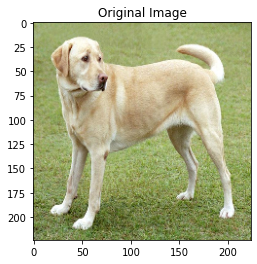

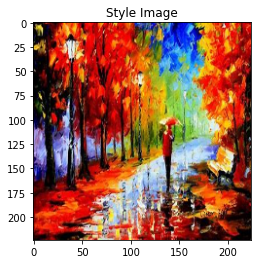

In [ ]:
%matplotlib inline 


def load_image (img_path):
  img = tf.io.read_file(img_path)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = img[tf.newaxis, :]   #we are making sure that our image is in new array; here indexer grabs the entire image
  return img



content_image = cv2.resize(cv2.imread('/content/drive/MyDrive/Colab Notebooks/Images/YellowLabradorLooking_new.jpg'),(224,224))\
#content_image = load_image('/content/drive/MyDrive/Colab Notebooks/Images/YellowLabradorLooking_new.jpg')
content_image = tf.image.convert_image_dtype(content_image, tf.float32)


style_image = cv2.resize(cv2.imread('/content/drive/MyDrive/Colab Notebooks/Images/Evening.jfif'),(224,224))
#style_image = load_image('/content/drive/MyDrive/Colab Notebooks/Images/Vassily_Kandinsky,_1913_-_Composition_7.jpg')
style_image = tf.image.convert_image_dtype(style_image, tf.float32)


plt.imshow(cv2.cvtColor(np.squeeze(content_image), cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.show()

plt.imshow(cv2.cvtColor(np.squeeze(style_image), cv2.COLOR_BGR2RGB))
plt.title("Style Image")
plt.show()

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.01, beta_1 = 0.9, epsilon=1e-1)

In [ ]:
def loss_object(style_output, content_output, style_target, content_target):
  content_weight = 1e-1
  style_weight = 5
  content_loss= tf.reduce_mean((content_output - content_target)**2)
  style_loss= tf.add_n([tf.reduce_mean((output_ - target_)**2) for output_, target_ in zip(style_output, style_target)])
  total_loss = content_weight * content_loss + style_weight*style_loss
  return total_loss


In [ ]:
content_image.shape

TensorShape([224, 224, 3])

In [ ]:
vgg_model = load_vgg()

content_target = vgg_model(np.array([content_image*255]))[0]
style_target = vgg_model(np.array([style_image*255]))[1]

In [ ]:
def train_step(image, epoch):
  with tf.GradientTape() as tape:
    output = vgg_model(image*255)
    loss = loss_object(output[1], output[0], style_target, content_target)
  gradient = tape.gradient(loss, image)
  opt.apply_gradients([(gradient, image)])
  image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

  if epoch % 10 ==0:
    tf.print(f"Loss = {loss}")


In [ ]:
EPOCHS = 100
image = tf.image.convert_image_dtype(content_image, tf.float32)
image = tf.Variable([image])
for i in range(EPOCHS):
  train_step(image, i)

Loss = 6679030136832.0
Loss = 776733786112.0
Loss = 380787458048.0
Loss = 196990779392.0
Loss = 131803488256.0
Loss = 99882360832.0
Loss = 80908378112.0
Loss = 68639301632.0
Loss = 60184264704.0
Loss = 54044864512.0


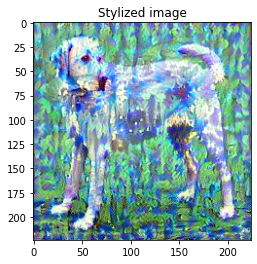

In [ ]:

plt.imshow(np.squeeze(image))
plt.title("Stylized image")
plt.show()